---
---
# **`CASE STUDY - 1` :: Healthcare Provider Fraudulent Detection**

<img src="Display_Pic.png" alt="drawing" width="950"/>

---
---


**This notebook contains the feature engineering :-**
   - **Final Model Pipelining**


**Above steps are performed on the publicly available dataset at [Kaggle](https://www.kaggle.com/datasets/rohitrox/healthcare-provider-fraud-detection-analysis).**


**Kindly checkout below link for gaining BUSINESS related insights related to this problem ::**

- [Deck : Detailed Explanation](https://docs.google.com/presentation/d/1Thuw_eZskafkl9W3xYuEVsjgTJKFeEkzEfAmczH96Uw/)


**Kindly checkout below link for TECHNICAL design document ::**

- [Technical Document](https://docs.google.com/document/d/10z9xbn4dZWkforlAszCDaa1M0roAW-MOf2pjJHSnEXk/)


**Kindly checkout below link for In-depth Description and Reasoning of all the Features ::**

- [Features Description](https://docs.google.com/spreadsheets/d/1ktwjad3U-hGT_7yccGyZC4AzGhWAMs3RHrIMk8Gi8xQ/)

# **`Notebook Contents`**

>[CASE STUDY - 1 :: Healthcare Provider Fraudulent Detection](#scrollTo=naPWqtUVigTd)

>[Notebook Contents](#scrollTo=PHkkU2ExpgPR)

>>[Importing_Libraries](#scrollTo=ThPD8j4PnuVH)

>>[Unseen_Data_Files](#scrollTo=c16_htZKnucm)

>>[Final_Pipeline](#scrollTo=eAXKdt1pyngk)

>>>[SUMMARY](#scrollTo=r-VhXYclyng3)

>>[Performance_on_TRAIN_and_VALIDATION_Sets](#scrollTo=0IC2VKpXyng4)

>>>[SUMMARY](#scrollTo=ZfOButQ2ynhB)



## **Importing_Libraries**

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

%matplotlib inline

In [3]:
pd.set_option('display.max_columns',80)
label_font_dict = {'family':'sans-serif','size':13.5,'color':'brown','style':'italic'}
title_font_dict = {'family':'sans-serif','size':16.5,'color':'Blue','style':'italic'}

## **Unseen_Data_Files**

In [4]:
# Unseen dataset files
bene_file = "Test_Beneficiarydata-1542969243754.csv"
ip_file = "Test_Inpatientdata-1542969243754.csv"
op_file = "Test_Outpatientdata-1542969243754.csv"
tgt_lbl_file = "Test-1542969243754.csv"

# Folder hierarchies 
folder_1 = "Dataset"
folder_2 = "TEST"
data_files_loc = os.path.join(os.path.join(os.getcwd(), folder_1), folder_2)
print("### Location where we have all the unseen data files --> {}".format(data_files_loc))

### Location where we have all the unseen data files --> E:\STUDY\PROJECTS\AAIC_Case_Study_1\Dataset\TEST


## **Final_Pipeline**

In [5]:
def unseen_data_files_names(files_loc, bene_data, ip_data, op_data, tgt_lbl_data):
    """
    Description : This function is created for reading the files names of BENEFICIARIES, IN-PATIENT, OUT-PATIENT and TGT_LABELS.
    """
    # Generating the unseen data files names
    bene_file_name = os.path.join(files_loc, bene_data)
    ip_file_name = os.path.join(files_loc, ip_data)
    op_file_name = os.path.join(files_loc, op_data)
    tgt_label_name = os.path.join(files_loc, tgt_lbl_data)
    return bene_file_name, ip_file_name, op_file_name, tgt_label_name

In [6]:
def read_unseen_data(unseen_data_loc, b_file, i_file, o_file, tgt_file):
    """
    Description : This function is created for reading the data based on the files names of BENEFICIARIES, IN-PATIENT, OUT-PATIENT
    and TGT_LABELS.
    """
    # Reading the data files names
    bene_unseen_data, ip_unseen_data, op_unseen_data, tgt_lbl_unseen_data = unseen_data_files_names(files_loc=unseen_data_loc,
                                                                                                    bene_data=b_file,
                                                                                                    ip_data=i_file,
                                                                                                    op_data=o_file,
                                                                                                    tgt_lbl_data=tgt_file)
    # Reading the data files
    unseen_bene_df = pd.read_csv(bene_unseen_data)
    unseen_ip_df = pd.read_csv(ip_unseen_data)
    unseen_op_df = pd.read_csv(op_unseen_data)
    unseen_tgt_lbls_df = pd.read_csv(tgt_lbl_unseen_data)
    
    # Creating a dictionary which will contain all the unseen data files
    entire_unseen_data = {"Unseen_Provider":unseen_tgt_lbls_df,
                          "Unseen_Beneficiary":unseen_bene_df,
                          "Unseen_Inpatient":unseen_ip_df,
                          "Unseen_Outpatient":unseen_op_df}
    return entire_unseen_data

In [7]:
# Generating the unseen data dictionary
unseen_data_dict = read_unseen_data(unseen_data_loc=data_files_loc,
                                    b_file=bene_file,
                                    i_file=ip_file,
                                    o_file=op_file,
                                    tgt_file=tgt_lbl_file)

In [8]:
def pre_process(X_input):
    """
    Description : This function is created for pre-processing the data files based on the feature engineering performed while training 
    the best model.
    """ 
    # Load the unseen data files
    test_tgt_lbls_df = X_input['Unseen_Provider']
    test_bene_df = X_input['Unseen_Beneficiary']
    test_ip_df = X_input['Unseen_Inpatient']
    test_op_df = X_input['Unseen_Outpatient']
       
    # Adding Feature - 1
    test_ip_df["Admitted?"] = 1
    test_op_df["Admitted?"] = 0

    # Commom columns must be 28
    common_cols = [col for col in test_ip_df.columns if col in test_op_df.columns]
    
    # Merging the IP and OP dataset on the basis of common columns
    test_ip_op_df = pd.merge(left=test_ip_df, right=test_op_df, left_on=common_cols, right_on=common_cols, how="outer")
    
    # Joining the IP_OP dataset with the BENE data
    test_ip_op_bene_df = pd.merge(left=test_ip_op_df, right=test_bene_df, left_on='BeneID', right_on='BeneID',how='inner')
    
    # Joining the IP_OP_BENE dataset with the Tgt Label Provider Data
    test_iobp_df = pd.merge(left=test_ip_op_bene_df, right=test_tgt_lbls_df, left_on='Provider', right_on='Provider',how='inner')
    
    # Joining with the PRV Tgt Labels
    prvs_claims_df = pd.DataFrame(test_iobp_df.groupby(['Provider'])['ClaimID'].count()).reset_index()
    prvs_claims_tgt_lbls_df = pd.merge(left=prvs_claims_df, right=test_tgt_lbls_df, on='Provider', how='inner')
    
    # Adding Feature - 2
    test_iobp_df['DOB'] = pd.to_datetime(test_iobp_df['DOB'], format="%Y-%m-%d")
    test_iobp_df['DOD'] = pd.to_datetime(test_iobp_df['DOD'], format="%Y-%m-%d")
    test_iobp_df['Is_Alive?'] = test_iobp_df['DOD'].apply(lambda val: 'No' if val != val else 'Yes')

    # Adding Feature - 3
    test_iobp_df['ClaimStartDt'] = pd.to_datetime(test_iobp_df['ClaimStartDt'], format="%Y-%m-%d")
    test_iobp_df['ClaimEndDt'] = pd.to_datetime(test_iobp_df['ClaimEndDt'], format="%Y-%m-%d")
    test_iobp_df['Claim_Duration'] = (test_iobp_df['ClaimEndDt'] - test_iobp_df['ClaimStartDt']).dt.days

    # Adding Feature - 4
    test_iobp_df['AdmissionDt'] = pd.to_datetime(test_iobp_df['AdmissionDt'], format="%Y-%m-%d")
    test_iobp_df['DischargeDt'] = pd.to_datetime(test_iobp_df['DischargeDt'], format="%Y-%m-%d")
    test_iobp_df['Admitted_Duration'] = (test_iobp_df['DischargeDt'] - test_iobp_df['AdmissionDt']).dt.days

    # Adding Feature - 5
    # Filling the Null values as MAX Date of Death in the Dataset
    test_iobp_df['DOD'].fillna(value=pd.to_datetime('2009-12-01',format ='%Y-%m-%d'), inplace=True)
    test_iobp_df['Bene_Age'] = round(((test_iobp_df['DOD'] - test_iobp_df['DOB']).dt.days)/365,1)

    # Adding Feature - 6
    test_iobp_df['Att_Phy_tot_claims'] = test_iobp_df.groupby(['AttendingPhysician'])['ClaimID'].transform('count')
    test_iobp_df['Opr_Phy_tot_claims'] = test_iobp_df.groupby(['OperatingPhysician'])['ClaimID'].transform('count')
    test_iobp_df['Oth_Phy_tot_claims'] = test_iobp_df.groupby(['OtherPhysician'])['ClaimID'].transform('count')
    test_iobp_df['Att_Phy_tot_claims'].fillna(value=0, inplace=True)
    test_iobp_df['Opr_Phy_tot_claims'].fillna(value=0, inplace=True)
    test_iobp_df['Oth_Phy_tot_claims'].fillna(value=0, inplace=True)
    test_iobp_df['Att_Opr_Oth_Phy_Tot_Claims'] = test_iobp_df['Att_Phy_tot_claims'] + test_iobp_df['Opr_Phy_tot_claims'] + test_iobp_df['Oth_Phy_tot_claims']
    test_iobp_df.drop(['Att_Phy_tot_claims', 'Opr_Phy_tot_claims', 'Oth_Phy_tot_claims'], axis=1, inplace=True)

    # Adding Feature - 7
    test_iobp_df["Prv_Tot_Att_Phy"] = test_iobp_df.groupby(['Provider'])['AttendingPhysician'].transform('count')
    test_iobp_df["Prv_Tot_Opr_Phy"] = test_iobp_df.groupby(['Provider'])['OperatingPhysician'].transform('count')
    test_iobp_df["Prv_Tot_Oth_Phy"] = test_iobp_df.groupby(['Provider'])['OtherPhysician'].transform('count')
    test_iobp_df['Prv_Tot_Att_Phy'].fillna(value=0, inplace=True)
    test_iobp_df['Prv_Tot_Opr_Phy'].fillna(value=0, inplace=True)
    test_iobp_df['Prv_Tot_Oth_Phy'].fillna(value=0, inplace=True)
    test_iobp_df['Prv_Tot_Att_Opr_Oth_Phys'] = test_iobp_df['Prv_Tot_Att_Phy'] + test_iobp_df['Prv_Tot_Opr_Phy'] + test_iobp_df['Prv_Tot_Oth_Phy']
    test_iobp_df.drop(['Prv_Tot_Att_Phy', 'Prv_Tot_Opr_Phy', 'Prv_Tot_Oth_Phy'], axis=1, inplace=True)

    # Adding Feature - 8
    test_iobp_df['PRV_Tot_Admit_DCodes'] = test_iobp_df.groupby(['Provider'])['ClmAdmitDiagnosisCode'].transform('nunique')

    # Adding Feature - 9
    test_iobp_df['PRV_Tot_DGrpCodes'] = test_iobp_df.groupby(['Provider'])['DiagnosisGroupCode'].transform('nunique')

    # Adding Feature - 10
    test_iobp_df['DOB_Year'] = test_iobp_df['DOB'].dt.year
    test_iobp_df['PRV_Tot_Unq_DOB_Years'] = test_iobp_df.groupby(['Provider'])['DOB_Year'].transform('nunique')
    test_iobp_df.drop(['DOB_Year'], axis=1, inplace=True)

    # Adding Feature - 11
    test_iobp_df['PRV_Bene_Age_Sum'] = test_iobp_df.groupby(['Provider'])['Bene_Age'].transform('sum')

    # Adding Feature - 12
    test_iobp_df['PRV_Insc_Clm_ReImb_Amt'] = test_iobp_df.groupby(['Provider'])['InscClaimAmtReimbursed'].transform('sum')

    # Adding Feature - 13
    test_iobp_df['RenalDiseaseIndicator'] = test_iobp_df['RenalDiseaseIndicator'].apply(lambda val: 1 if val == "Y" else 0)
    test_iobp_df['PRV_Tot_RKD_Patients'] = test_iobp_df.groupby(['Provider'])['RenalDiseaseIndicator'].transform('sum')
    test_iobp_df.drop(['NoOfMonths_PartACov', 'NoOfMonths_PartBCov'], axis=1, inplace=True)
    test_iobp_df['Admitted_Duration'].fillna(value=0,inplace=True)

    # PRV Aggregate features
    test_iobp_df["PRV_CoPayment"] = test_iobp_df.groupby('Provider')['DeductibleAmtPaid'].transform('sum')
    test_iobp_df["PRV_IP_Annual_ReImb_Amt"] = test_iobp_df.groupby('Provider')['IPAnnualReimbursementAmt'].transform('sum')
    test_iobp_df["PRV_IP_Annual_Ded_Amt"] = test_iobp_df.groupby('Provider')['IPAnnualDeductibleAmt'].transform('sum')
    test_iobp_df["PRV_OP_Annual_ReImb_Amt"] = test_iobp_df.groupby('Provider')['OPAnnualReimbursementAmt'].transform('sum')
    test_iobp_df["PRV_OP_Annual_Ded_Amt"] = test_iobp_df.groupby('Provider')['OPAnnualDeductibleAmt'].transform('sum')
    test_iobp_df["PRV_Admit_Duration"] = test_iobp_df.groupby('Provider')['Admitted_Duration'].transform('sum')
    test_iobp_df["PRV_Claim_Duration"] = test_iobp_df.groupby('Provider')['Claim_Duration'].transform('sum')

    def create_agg_feats(grp_col, feat_name, operation='sum'):
        """
        Description :: This function is created for adding the aggregated features in the dataset for every level like:
            - Beneficiary
            - Attending Physician
            - Operating Physician
            - Other Physician and etc..

        Input Parameters :: It accepts below inputs:
            - grp_col : `str`
                - It represents the feature or level at which you want to perform the aggregation.

            - feat_name : `str`
                - It represents the feature whose aggregated aspect you want to capture.

            - operation : `str`
                - It represents the aggregation operation you want to perform.(By default it is SUM)
        """
        feat_1 = feat_name + "_Insc_ReImb_Amt"
        test_iobp_df[feat_1] = test_iobp_df.groupby(grp_col)['InscClaimAmtReimbursed'].transform(operation)

        feat_2 = feat_name + "_CoPayment"
        test_iobp_df[feat_2] = test_iobp_df.groupby(grp_col)['DeductibleAmtPaid'].transform(operation)

        feat_3 = feat_name + "_IP_Annual_ReImb_Amt"
        test_iobp_df[feat_3] = test_iobp_df.groupby(grp_col)['IPAnnualReimbursementAmt'].transform(operation)

        feat_4 = feat_name + "_IP_Annual_Ded_Amt"
        test_iobp_df[feat_4] = test_iobp_df.groupby(grp_col)['IPAnnualDeductibleAmt'].transform(operation)

        feat_5 = feat_name + "_OP_Annual_ReImb_Amt"
        test_iobp_df[feat_5] = test_iobp_df.groupby(grp_col)['OPAnnualReimbursementAmt'].transform(operation)

        feat_6 = feat_name + "_OP_Annual_Ded_Amt"
        test_iobp_df[feat_6] = test_iobp_df.groupby(grp_col)['OPAnnualDeductibleAmt'].transform(operation)

        feat_7 = feat_name + "_Admit_Duration"
        test_iobp_df[feat_7] = test_iobp_df.groupby(grp_col)['Admitted_Duration'].transform(operation)

        feat_8 = feat_name + "_Claim_Duration"
        test_iobp_df[feat_8] = test_iobp_df.groupby(grp_col)['Claim_Duration'].transform(operation)
      
    # BENE, PHYs, Diagnosis Admit and Group Codes columns
    create_agg_feats(grp_col='BeneID', feat_name="BENE")
    create_agg_feats(grp_col='AttendingPhysician', feat_name="ATT_PHY")
    create_agg_feats(grp_col='OperatingPhysician', feat_name="OPT_PHY")
    create_agg_feats(grp_col='OtherPhysician', feat_name="OTH_PHY")
    create_agg_feats(grp_col='ClmAdmitDiagnosisCode', feat_name="Claim_Admit_Diag_Code")
    create_agg_feats(grp_col='DiagnosisGroupCode', feat_name="Diag_GCode")

    # Dropping these 3 columns as there 99% of values are same
    test_iobp_df.drop(['ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6'], axis=1, inplace=True)

    # Diagnosis Codes columns
    create_agg_feats(grp_col='ClmDiagnosisCode_1', feat_name="Claim_DiagCode1")
    create_agg_feats(grp_col='ClmDiagnosisCode_2', feat_name="Claim_DiagCode2")
    create_agg_feats(grp_col='ClmDiagnosisCode_3', feat_name="Claim_DiagCode3")
    create_agg_feats(grp_col='ClmDiagnosisCode_4', feat_name="Claim_DiagCode4")
    create_agg_feats(grp_col='ClmDiagnosisCode_5', feat_name="Claim_DiagCode5")
    create_agg_feats(grp_col='ClmDiagnosisCode_6', feat_name="Claim_DiagCode6")
    create_agg_feats(grp_col='ClmDiagnosisCode_7', feat_name="Claim_DiagCode7")
    create_agg_feats(grp_col='ClmDiagnosisCode_8', feat_name="Claim_DiagCode8")
    create_agg_feats(grp_col='ClmDiagnosisCode_9', feat_name="Claim_DiagCode9")
    create_agg_feats(grp_col='ClmDiagnosisCode_10', feat_name="Claim_DiagCode10")

    # Medical Procedure Codes columns
    create_agg_feats(grp_col='ClmProcedureCode_1', feat_name="Claim_ProcCode1")
    create_agg_feats(grp_col='ClmProcedureCode_2', feat_name="Claim_ProcCode2")
    create_agg_feats(grp_col='ClmProcedureCode_3', feat_name="Claim_ProcCode3")

    # PROVIDER <--> other features :: To get claim counts
    test_iobp_df["ClmCount_Provider"]=test_iobp_df.groupby(['Provider'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID"]=test_iobp_df.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_AttendingPhysician"]=test_iobp_df.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_OtherPhysician"]=test_iobp_df.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_OperatingPhysician"]=test_iobp_df.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmAdmitDiagnosisCode"]=test_iobp_df.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmDiagnosisCode_1"]=test_iobp_df.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmDiagnosisCode_2"]=test_iobp_df.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmDiagnosisCode_3"]=test_iobp_df.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmDiagnosisCode_4"]=test_iobp_df.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmDiagnosisCode_5"]=test_iobp_df.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmDiagnosisCode_6"]=test_iobp_df.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmDiagnosisCode_7"]=test_iobp_df.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmDiagnosisCode_8"]=test_iobp_df.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmDiagnosisCode_9"]=test_iobp_df.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_ClmDiagnosisCode_10"]=test_iobp_df.groupby(['Provider','ClmDiagnosisCode_10'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_DiagnosisGroupCode"]=test_iobp_df.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')

    # PROVIDER <--> BENE <--> PHYSICIANS :: To get claim counts
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician'])['ClaimID'].transform('count')

    # PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

    # PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

    # PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> PROCEDURE CODES :: To get claim counts
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmProcedureCode_3'])['ClaimID'].transform('count')

    # PROVIDER <--> BENE <--> ATTENDING PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_1"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_2"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_3"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_4"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_5"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_6"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_7"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_8"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_9"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_AttendingPhysician_ClmDiagnosisCode_10"]=test_iobp_df.groupby(['Provider','BeneID','AttendingPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

    # PROVIDER <--> BENE <--> OPERATING PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_1"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_2"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_3"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_4"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_5"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_6"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_7"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_8"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_9"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OperatingPhysician_ClmDiagnosisCode_10"]=test_iobp_df.groupby(['Provider','BeneID','OperatingPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

    # PROVIDER <--> BENE <--> OTHER PHYSICIAN <--> DIAGNOSIS CODES :: To get claim counts
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_1"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_2"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_3"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_4"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_5"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_6"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_7"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_8"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_9"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_OtherPhysician_ClmDiagnosisCode_10"]=test_iobp_df.groupby(['Provider','BeneID','OtherPhysician','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

    # PROVIDER <--> BENE <--> PROCEDURE CODES :: To get claim counts
    test_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmProcedureCode_3'])['ClaimID'].transform('count')

    # PROVIDER <--> BENE <--> DIAGNOSIS CODES :: To get claim counts
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10'])['ClaimID'].transform('count')

    # PROVIDER <--> BENE <--> DIAGNOSIS CODES <--> PROCEDURE CODES :: To get claim counts
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_1_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_1','ClmProcedureCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_2_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_2','ClmProcedureCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_3_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_3','ClmProcedureCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_4_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_4','ClmProcedureCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_5_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_5','ClmProcedureCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_6_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_6','ClmProcedureCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_7_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_7','ClmProcedureCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_8_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_8','ClmProcedureCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_9_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_9','ClmProcedureCode_3'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_1"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_1'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_2"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_2'])['ClaimID'].transform('count')
    test_iobp_df["ClmCount_Provider_BeneID_ClmDiagnosisCode_10_ClmProcedureCode_3"]=test_iobp_df.groupby(['Provider','BeneID','ClmDiagnosisCode_10','ClmProcedureCode_3'])['ClaimID'].transform('count')

    # Removing unwanted columns
    remove_unwanted_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                          'AdmissionDt', 'ClmAdmitDiagnosisCode', 'DischargeDt', 'DiagnosisGroupCode',
                          'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 
                          'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                          'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3', 'DOB', 'DOD', 'State', 'County']

    test_iobp_df.drop(columns=remove_unwanted_columns, axis=1, inplace=True)

    # Filling Nulls in Deductible Amt Paid by Patient
    test_iobp_df['DeductibleAmtPaid'].fillna(value=0, inplace=True)

    # Binary encoding the categorical features --> 0 means No and 1 means Yes
    test_iobp_df['Gender'] = test_iobp_df['Gender'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['Is_Alive?'] = test_iobp_df['Is_Alive?'].apply(lambda val: 0 if val == "No" else 1)

    test_iobp_df['ChronicCond_Alzheimer'] = test_iobp_df['ChronicCond_Alzheimer'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['ChronicCond_Heartfailure'] = test_iobp_df['ChronicCond_Heartfailure'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['ChronicCond_KidneyDisease'] = test_iobp_df['ChronicCond_KidneyDisease'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['ChronicCond_Cancer'] = test_iobp_df['ChronicCond_Cancer'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['ChronicCond_ObstrPulmonary'] = test_iobp_df['ChronicCond_ObstrPulmonary'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['ChronicCond_Depression'] = test_iobp_df['ChronicCond_Depression'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['ChronicCond_Diabetes'] = test_iobp_df['ChronicCond_Diabetes'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['ChronicCond_IschemicHeart'] = test_iobp_df['ChronicCond_IschemicHeart'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['ChronicCond_Osteoporasis'] = test_iobp_df['ChronicCond_Osteoporasis'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['ChronicCond_rheumatoidarthritis'] = test_iobp_df['ChronicCond_rheumatoidarthritis'].apply(lambda val: 0 if val == 2 else val)
    test_iobp_df['ChronicCond_stroke'] = test_iobp_df['ChronicCond_stroke'].apply(lambda val: 0 if val == 2 else val)

    # Encoding the Categorical features
    test_iobp_df = pd.get_dummies(test_iobp_df,columns=['Gender', 'Race', 'Admitted?', 'Is_Alive?'], drop_first=True)

    # Filling Nulls in the aggregated features
    test_iobp_df.fillna(value=0, inplace=True)

    # Grouping the records
    test_iobp_df = test_iobp_df.groupby(['Provider'],as_index=False).agg('sum')

    # Segregating the sets
    X_unseen = test_iobp_df.drop(axis=1, columns=['Provider'])
    y_unseen_prvs = test_iobp_df['Provider']

    return X_unseen, y_unseen_prvs

In [9]:
X_unseen_pp, y_unseen_pp = pre_process(unseen_data_dict)

In [10]:
# Checking shape of unseen data after pre-processing it should have 299 features
X_unseen_pp.shape, y_unseen_pp.shape

((1353, 299), (1353,))

In [11]:
X_unseen_pp.to_csv("X_unseen_pp.csv")
y_unseen_pp.to_csv("y_unseen_pp.csv")

In [16]:
pd.read_csv("y_unseen_pp.csv", index_col=0)

,Provider
0,PRV51002
1,PRV51006
2,PRV51009
3,PRV51010
4,PRV51018
...,...
1348,PRV57713
1349,PRV57726
1350,PRV57745
1351,PRV57749


In [32]:
# Loading the best model
rfc_3 = joblib.load('best_model.pkl')

In [33]:
# Making the predictions on the unseen data
unseen_preds = rfc_3.predict(X_unseen_pp)

In [39]:
# Generating the predictions probabilities on the unseen data
unseen_preds_probs = rfc_3.predict_proba(X_unseen_pp)
unseen_preds_probs_df = pd.DataFrame(unseen_preds_probs)
unseen_preds_probs_df.columns=['Class_0', 'Class_1']
unseen_preds_probs_df

,Class_0,Class_1
0,0.088072,0.911928
1,0.273612,0.726388
2,0.107149,0.892851
3,0.077191,0.922809
4,0.084086,0.915914
...,...,...
1348,0.803848,0.196152
1349,0.708234,0.291766
1350,0.828519,0.171481
1351,0.222062,0.777938


In [42]:
# Predicted Results of all the providers
unseen_results = pd.concat([pd.DataFrame(y_unseen_pp), pd.DataFrame(unseen_preds), unseen_preds_probs_df],axis=1)
unseen_results.reset_index(drop=True, inplace=True)
unseen_results.columns = ['Providers','Potential_Fraud?', 'Non_Fraud_Prob_Score', 'Fraud_Prob_Score']
unseen_results

,Providers,Potential_Fraud?,Non_Fraud_Prob_Score,Fraud_Prob_Score
0,PRV51002,1,0.088072,0.911928
1,PRV51006,1,0.273612,0.726388
2,PRV51009,1,0.107149,0.892851
3,PRV51010,1,0.077191,0.922809
4,PRV51018,1,0.084086,0.915914
...,...,...,...,...
1348,PRV57713,0,0.803848,0.196152
1349,PRV57726,0,0.708234,0.291766
1350,PRV57745,0,0.828519,0.171481
1351,PRV57749,1,0.222062,0.777938


In [51]:
# Check whether a specific PROVIDER is frauster or not?
unseen_results[unseen_results['Providers'] == 'PRV51009']

,Providers,Potential_Fraud?,Non_Fraud_Prob_Score,Fraud_Prob_Score
2,PRV51009,1,0.107149,0.892851


### **`SUMMARY`**
- Here, we have generated the predictions from the best-trained model on the unseen dataset.

## **Performance_on_TRAIN_and_VALIDATION_Sets**

In [20]:
def pred_prob(clf, data): 
    """
    Description :: This function is created for storing the predicted probabability using the trained model.
    
    Input :: It accepts below input parameters :
      - clf : Trained model classifier
      - data : Dataset for which we want to generate the predictions
    """
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def draw_roc(train_fpr, train_tpr, test_fpr, test_tpr):
    """
    Description :: This function is created for calculating the AUC score on train and test data. And, plotting the ROC curve.
    
    Input :: It accepts below input parameters :
      - train_fpr : Train False +ve rate
      - train_tpr : Train True +ve rate
      - test_fpr : Test False +ve rate
      - test_tpr : Test True +ve rate
    """
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    test_auc = auc(test_fpr, test_tpr)
    with plt.style.context('seaborn-poster'):
      plt.plot(train_fpr, train_tpr, label="Train AUC ="+"{:.4f}".format(train_auc), color='blue')
      plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc), color='red')
      plt.legend()
      plt.xlabel("False Positive Rate(FPR)", fontdict=label_font_dict)
      plt.ylabel("True Positive Rate(TPR)", fontdict=label_font_dict)
      plt.title("Area Under Curve", fontdict=title_font_dict)
      plt.grid(b=True, which='major', color='lightgrey', linestyle='--')
      plt.minorticks_on()
      plt.show()
    
def find_best_threshold(threshold, fpr, tpr):
    """
    Description :: This function is created for finding the best threshold value.
    """
    t = threshold[np.argmax(tpr * (1-fpr))]
    return t

def predict_with_best_t(proba, threshold):
    """
    Description :: This function is created for generating the predictions based on the best threshold value.
    """
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred):
    """
    Description :: This function is created for plotting the confusion matrix of TRAIN and TEST sets.
    """
    fig, ax = plt.subplots(1,2, figsize=(20,6))

    train_prediction = predict_with_best_t(y_train_pred, best_t)
    cm = confusion_matrix(y_train, train_prediction)
    with plt.style.context('seaborn'):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax[0], cmap='viridis')
        ax[0].set_title('Train Dataset Confusion Matrix', fontdict=title_font_dict)
        ax[0].set_xlabel("Predicted Label", fontdict=label_font_dict)
        ax[0].set_ylabel("Actual Label", fontdict=label_font_dict)

    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    with plt.style.context('seaborn'):
        sns.heatmap(cm, annot=True, fmt='d', ax=ax[1], cmap='summer')
        ax[1].set_title('Test Dataset Confusion Matrix', fontdict=title_font_dict)
        ax[1].set_xlabel("Predicted Label", fontdict=label_font_dict)
        ax[1].set_ylabel("Actual Label", fontdict=label_font_dict)
    
    plt.show()
    
    return train_prediction, test_prediction

In [21]:
def validate_model(clf, x_train, x_test, y_train, y_test):
    """
    Description :: This function is created for performing the evaluation of the trained model.
    """
    # predict the probability of train data
    y_train_pred = pred_prob(clf, x_train)
    
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    
    # calculate tpr, fpr using roc_curve
    train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    train_auc = auc(train_fpr, train_tpr)
    print("### Train AUC = {}".format(train_auc))
    test_auc = auc(test_fpr, test_tpr)
    print("### Test AUC = {}".format(test_auc))
    
    # plotting the ROC curve
    draw_roc(train_fpr, train_tpr, test_fpr, test_tpr)
    
    # Best threshold value
    best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
    
    # Plotting the confusion matrices
    train_prediction, test_prediction = draw_confusion_matrix(best_t, x_train, x_test, y_train, y_test, y_train_pred, y_test_pred)
    
    # Generating the F1-scores
    train_f1_score = f1_score(y_train, train_prediction)
    test_f1_score = f1_score(y_test, test_prediction)
    
    return test_auc, train_f1_score, test_f1_score, best_t

In [22]:
# Reading the TRAIN and VALIDATION sets for checking the model performance
X_train_std = pd.read_csv("X_train_std.csv", index_col=0)
X_test_std = pd.read_csv("X_test_std.csv", index_col=0)

y_train = pd.read_csv("y_train.csv", index_col=0)
y_test = pd.read_csv("y_test.csv", index_col=0)

In [23]:
np.ravel(y_test)

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

### Train AUC = 0.9464100603279804
### Test AUC = 0.9509593161150978


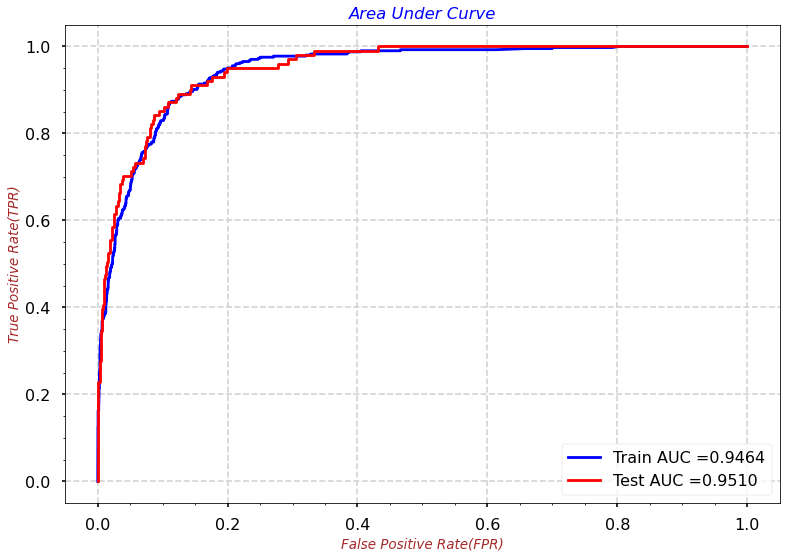

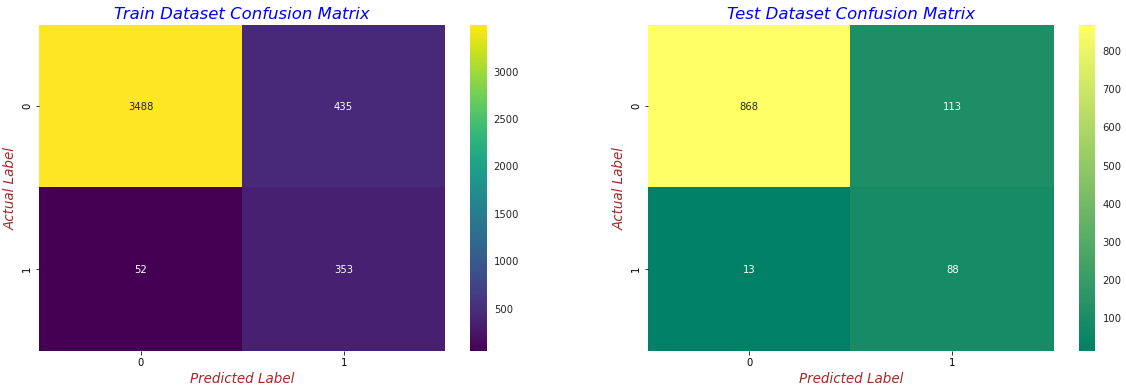



### Best Threshold = 0.5567
### Model AUC is : 0.9510
### Model Train F1 Score is : 0.5918
### Model Test F1 Score is : 0.5828


In [24]:
# Validate model
test_auc, train_f1_score, test_f1_score, best_t = validate_model(rfc_3, X_train_std, X_test_std, np.ravel(y_train), np.ravel(y_test))

print("\n")
print("### Best Threshold = {:.4f}".format(best_t))
print("### Model AUC is : {:.4f}".format(test_auc))
print("### Model Train F1 Score is : {:.4f}".format(train_f1_score))
print("### Model Test F1 Score is : {:.4f}".format(test_f1_score))

In [25]:
feats_imps_4 = pd.DataFrame({'Features': X_train_std.columns, 'Importance_Model_1': rfc_3.feature_importances_})
feats_imps_4 = feats_imps_4[feats_imps_4['Importance_Model_1'] != 0]
feats_imps_4.reset_index(drop=True, inplace=True)
feats_imps_4.head()

,Features,Importance_Model_1
0,InscClaimAmtReimbursed,0.065302
1,DeductibleAmtPaid,0.054782
2,RenalDiseaseIndicator,0.000297
3,ChronicCond_ObstrPulmonary,0.000880
4,ChronicCond_Osteoporasis,0.000377


In [26]:
top_20_pos_feats_4 = feats_imps_4.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Features'].iloc[0:20]
top_20_pos_feats_scores_4 = feats_imps_4.sort_values(by='Importance_Model_1',axis=0,ascending=False)['Importance_Model_1'].iloc[0:20]

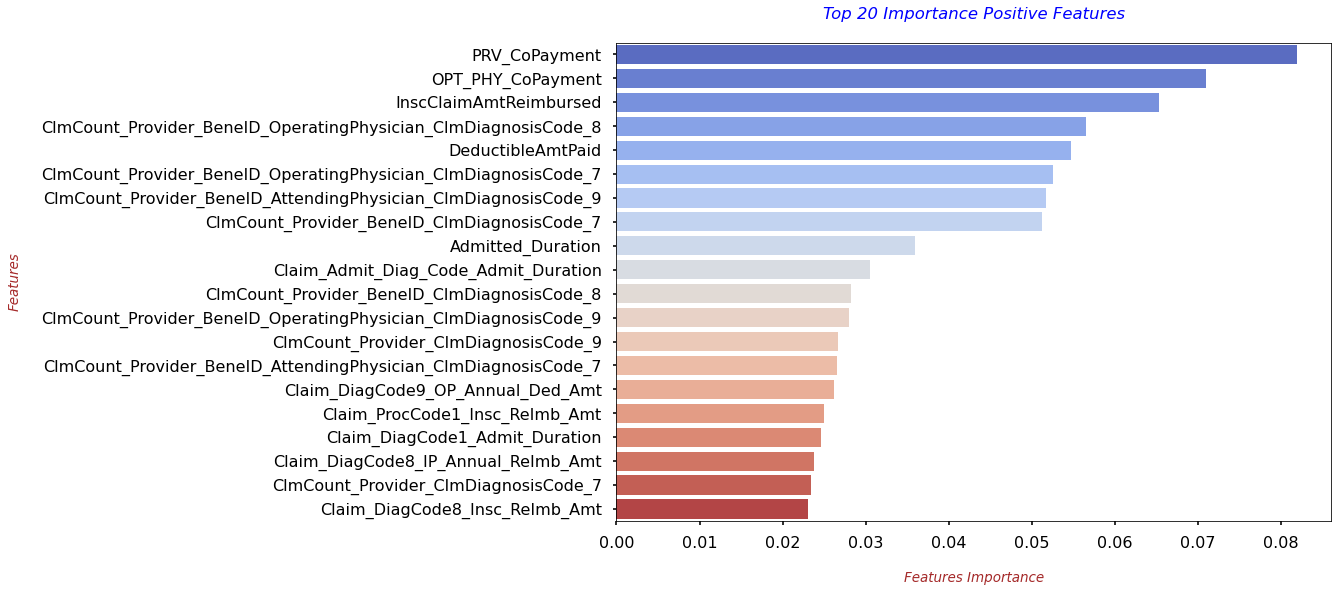

In [27]:
with plt.style.context('seaborn-poster'):
    sns.barplot(y=top_20_pos_feats_4, x=top_20_pos_feats_scores_4, orient='h', palette='coolwarm')
    plt.xlabel("\nFeatures Importance", fontdict=label_font_dict)
    plt.ylabel("Features\n", fontdict=label_font_dict)
    plt.title("Top 20 Importance Positive Features\n", fontdict=title_font_dict)

In [28]:
result_feats_scrs_4 = pd.DataFrame({'Feature': top_20_pos_feats_4, 'Imp_Score': top_20_pos_feats_scores_4})
result_feats_scrs_4

,Feature,Imp_Score
17,PRV_CoPayment,0.081920
35,OPT_PHY_CoPayment,0.070996
0,InscClaimAmtReimbursed,0.065302
145,ClmCount_Provider_BeneID_OperatingPhysician_Cl...,0.056550
1,DeductibleAmtPaid,0.054782
144,ClmCount_Provider_BeneID_OperatingPhysician_Cl...,0.052589
142,ClmCount_Provider_BeneID_AttendingPhysician_Cl...,0.051732
153,ClmCount_Provider_BeneID_ClmDiagnosisCode_7,0.051206
10,Admitted_Duration,0.035899
50,Claim_Admit_Diag_Code_Admit_Duration,0.030555


### **`SUMMARY`**
- Here, we have the most important features on the basis of which model is giving the predictions.